## Classify Radio Signals from Space with Keras

### Task 1: Import Libraries

In [3]:
!pip install livelossplot

In [5]:
!pip install tensorflow

  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4848 sha256=2c62e8424cb5d1938da667ca0e8f131d07084b3495b3db1154d1c025e5b1a55f
  Stored in directory: c:\users\morga\appdata\local\pip\cache\wheels\b6\0d\90\0d1bbd99855f99cb2f6c2e5ff96f8023fad8ec367695f7d72d
Successfully built termcolor


In [6]:
from livelossplot.tf_keras import PlotLossesCallback
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn import metrics

import numpy as np
np.random.seed(42)
import warnings;warnings.simplefilter('ignore')
%matplotlib inline
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.9.1


## Task 2: Load and Preprocess SETI Data

In [8]:
train_images = pd.read_csv('dataset/train/images.csv', header=None)
train_labels = pd.read_csv('dataset/train/labels.csv', header=None)

val_images = pd.read_csv('dataset/validation/images.csv', header=None)
val_labels = pd.read_csv('dataset/validation/labels.csv', header=None)

In [9]:
train_images.head(3)

,0,1,2,3,4,5,6,7,8,9,...,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,...,0.682353,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,...,0.721569,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490
2,0.717647,0.701961,0.713726,0.733333,0.705882,0.717647,0.725490,0.682353,0.717647,0.674510,...,0.709804,0.694118,0.705882,0.682353,0.639216,0.713726,0.670588,0.678431,0.737255,0.674510


In [10]:
train_labels.head(3)

,0,1,2,3
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0


In [11]:
print("Training set shape:", train_images.shape, train_labels.shape)
print("Validation set shape:", val_images.shape, val_labels.shape)

Training set shape: (3200, 8192) (3200, 4)
Validation set shape: (800, 8192) (800, 4)


In [13]:
x_train = train_images.values.reshape(3200, 64, 128, 1) #64*128 =8192
x_val = val_images.values.reshape(800, 64, 128, 1)

y_train = train_labels.values
y_val = val_labels.values

## Task 3: Plot 2D Spectrograms

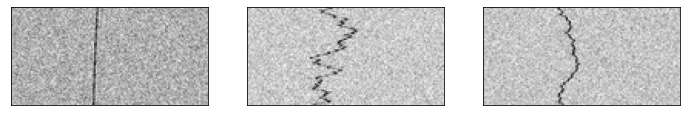

In [28]:
plt.figure(0, figsize=(12,12))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = np.squeeze(x_train[np.random.randint(0, x_train.shape[0])]) #np.squeeze will remove the 1 in (3200, 64, 128, 1) -->(3200,64,128)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap='gray') #<--- implement grayscale by changing code from plt.imshow(img) to --> plt.imshow(img, cmap='gray')

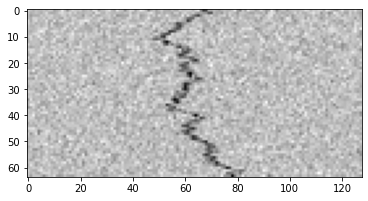

In [15]:
plt.imshow(np.squeeze(x_train[3]), cmap="gray"); #a

## Task 4: Create Training and Validation Data Generators

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(horizontal_flip=True)
datagen_train.fit(x_train)

datagen_val = ImageDataGenerator(horizontal_flip=True)
datagen_val.fit(x_val)

In [26]:
ImageDataGenerator? #view list of availabe functions.

## Task 5: Creating the CNN Model

In [17]:
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D # Dropout layer for Regularization.
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD #removing SGD is optional.
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

In [18]:
# Initialising the CNN 
model = Sequential()

# 1st Convolution
model.add(Conv2D(32,(5,5), padding='same', input_shape=(64, 128,1))) #1 is for grayscale image
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #Nonlinear downsampling. Partitiions images into sets of rectangles and finds the maximum value for that region
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(64,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25)) #for hyperparameter tuning

# Flattening
model.add(Flatten())

# Fully connected layer
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(4, activation='softmax')) #creates output probability, 1st and 2nd conv.NN  the flattening and fullconnected layer = 4 layers for the (4, actiovation = 'softmax')

## Task 6: Learning Rate Scheduling and Compile the Model

In [20]:
initial_learning_rate = 0.005 #.005 * (0.96**5) Learning rate * (decay_rate**decay_steps)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=5,
    decay_rate=0.96,
    staircase=True)

optimizer = Adam(learning_rate=lr_schedule)

In [21]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 128, 32)       832       
                                                                 
 batch_normalization (BatchN  (None, 64, 128, 32)      128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64, 128, 32)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 64, 64)        5

## Task 7: Training the Model

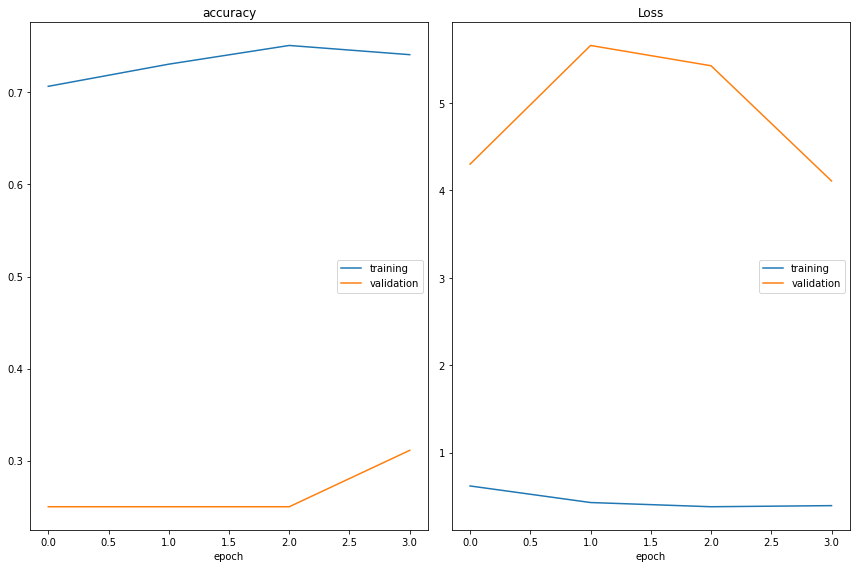

accuracy
	training         	 (min:    0.707, max:    0.751, cur:    0.741)
	validation       	 (min:    0.250, max:    0.311, cur:    0.311)
Loss
	training         	 (min:    0.381, max:    0.619, cur:    0.394)
	validation       	 (min:    4.109, max:    5.660, cur:    4.109)
100/100 [==============================] - 758s 8s/step - loss: 0.3941 - accuracy: 0.7409 - val_loss: 4.1090 - val_accuracy: 0.3113
Epoch 5/12
 25/100 [======>.......................] - ETA: 11:05 - loss: 0.3729 - accuracy: 0.7475

KeyboardInterrupt: 

In [22]:
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_loss', #save the model weights for model that has the minimum validation loss #Grab Some coffee This is going to take while
                             save_weights_only=True, mode='min', verbose=0)
callbacks = [PlotLossesCallback(), checkpoint]#, reduce_lr] #loglossplot #No need for tensorboard
batch_size = 32
history = model.fit(
    datagen_train.flow(x_train, y_train, batch_size=batch_size, shuffle=True),
    steps_per_epoch=len(x_train)//batch_size,
    validation_data = datagen_val.flow(x_val, y_val, batch_size=batch_size, shuffle=True),
    validation_steps = len(x_val)//batch_size,
    epochs=12,
    callbacks=callbacks
)

## Task 8: Model Evaluation

In [23]:
model.evaluate(x_val, y_val)

25/25 [==============================] - 25s 979ms/step - loss: 4.4928 - accuracy: 0.3000


[4.492818832397461, 0.30000001192092896]

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns

y_true = np.argmax(y_val, 1)
y_pred = np.argmax(model.predict(x_val), 1)
print(metrics.classification_report(y_true, y_pred))
print("Classification accuracy: %0.6f" % metrics.accuracy_score(y_true, y_pred))

25/25 [==============================] - 30s 1s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       200
           1       0.00      0.00      0.00       200
           2       0.26      1.00      0.42       200
           3       1.00      0.20      0.33       200

    accuracy                           0.30       800
   macro avg       0.32      0.30      0.19       800
weighted avg       0.32      0.30      0.19       800

Classification accuracy: 0.300000


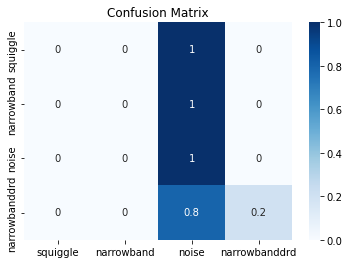

In [25]:
labels = ["squiggle", "narrowband", "noise", "narrowbanddrd"]

ax= plt.subplot()
sns.heatmap(metrics.confusion_matrix(y_true, y_pred, normalize='true'), annot=True, ax = ax, cmap=plt.cm.Blues); #annot=True to annotate cells

# labels, title and ticks
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

![RadioSpaceSignalClassificationKeras](https://user-images.githubusercontent.com/106122834/177062987-3cf1795f-255a-49fa-b9f5-67cc4285fdc7.jpeg)

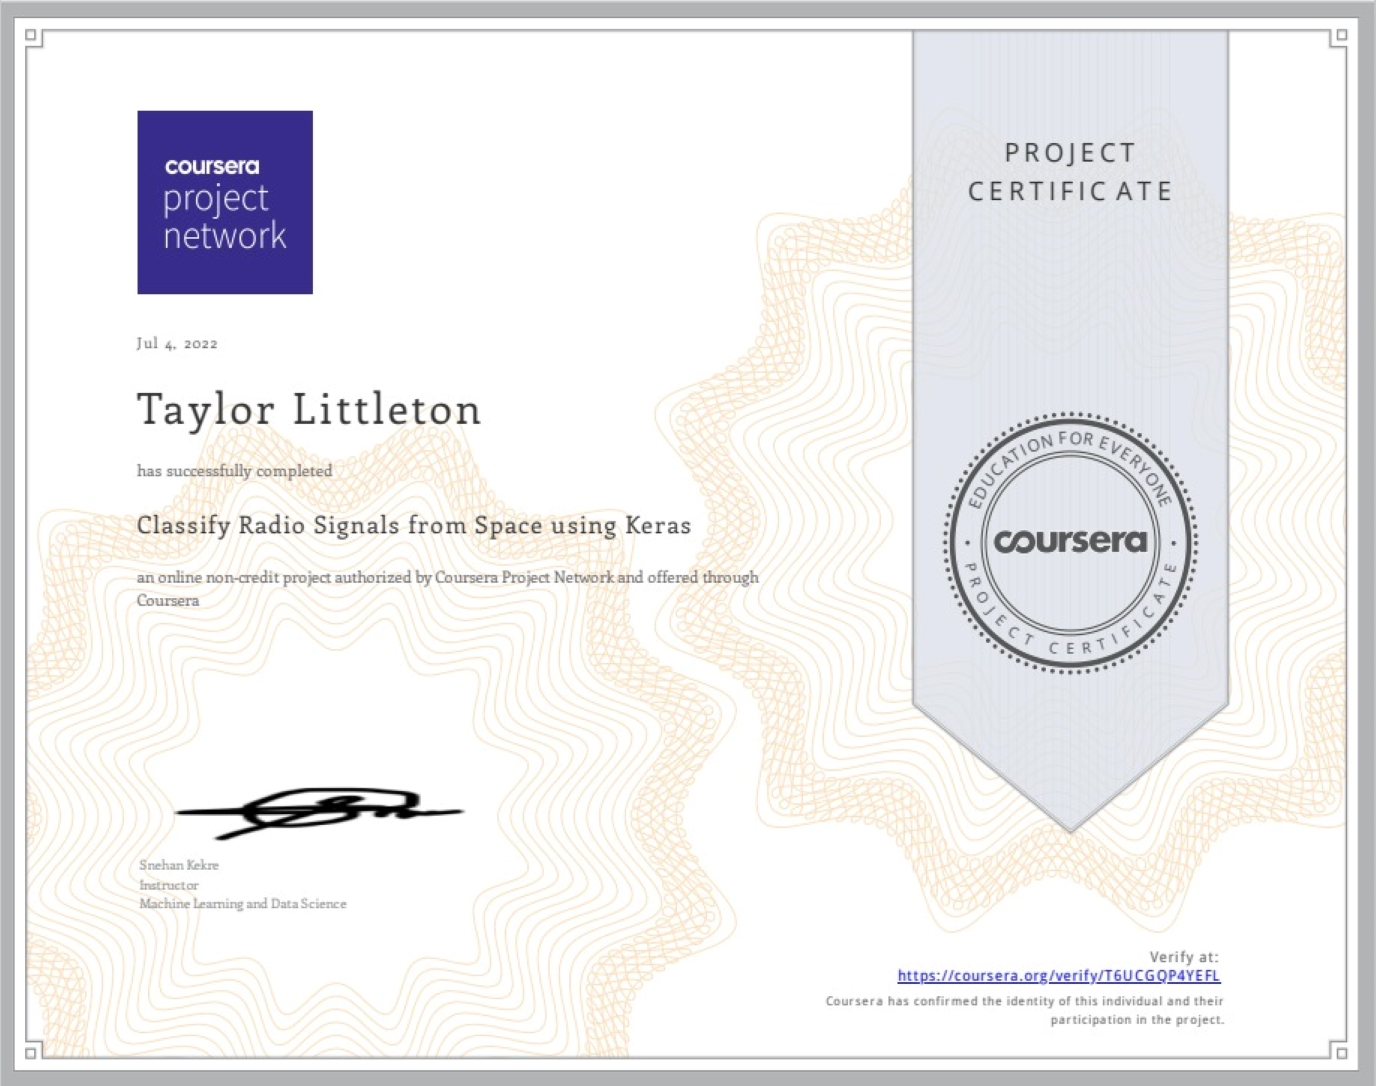